In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
import utils


%matplotlib inline

In [2]:
import utils

## 1 Logistic Regerssion

In [3]:
# Load data
data = np.loadtxt('ex2data1.txt', delimiter=',')
X, y = data[:, 0:2], data[:, 2]

### 1.1 Visualizing the data

In [4]:
def plotData(X, y):
    fig = pyplot.figure()
    pos = (y == 1)
    neg = (y == 0)
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)

Text(0, 0.5, 'Exam 2 score')

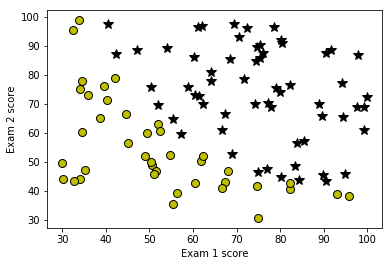

In [5]:
plotData(X, y)
pyplot.xlabel('Exam 1 score')
pyplot.ylabel('Exam 2 score')

### 1.2 Implementation

In [6]:
def sigmoid(z):
    z = np.array(z)
    g = np.zeros(z.shape)
    g = 1 / (1 + np.exp(-z))
    return g

In [7]:
# Test the implementation of sigmoid function here
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


In [8]:
m, n = X.shape

X = np.concatenate([np.ones((m,1)), X], axis = 1)

In [9]:
X[0:5,:]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [10]:
X.shape

(100, 3)

In [11]:
theta = np.ones(3)
theta.shape

(3,)

In [12]:
X.T.dot(y)

array([  60.        , 4483.1353618 , 4437.38412496])

In [13]:
def costFunction(theta, X, y):
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(X.dot(theta))
    J = -1/m*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    grad = 1/m*X.T.dot(h-y)
    
    return J, grad

In [14]:
# Initialize fitting parameters
initial_theta = np.zeros(n+1)

cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')


Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


#### Learning parameters using scipy.optimize

In [15]:
options = {'maxiter':400}

res = optimize.minimize(costFunction, initial_theta, (X,y), jac=True, method='TNC', options=options)

cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n');

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Expected theta (approx):\n\t[-25.161, 0.206, 0.201]')

Cost at theta found by optimize.minimize: 0.203
Expected cost (approx): 0.203

theta:
	[-25.161, 0.206, 0.201]
Expected theta (approx):
	[-25.161, 0.206, 0.201]


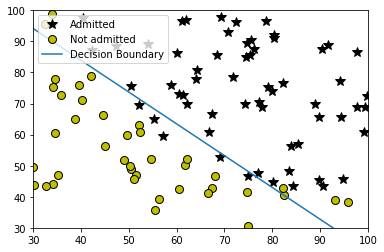

In [16]:
utils.plotDecisionBoundary(plotData, theta, X, y)

#### Evaluating logistic regression

In [17]:
def predict(theta, X, threshold=0.5):
    m = X.shape[0]
    p = np.zeros(m)
    p = sigmoid(X.dot(theta.T)) >= threshold
    p = p.astype('int')
    return p

In [18]:
#  Predict probability for a student with score 45 on exam 1 
#  and score 85 on exam 2 
prob = sigmoid(np.dot([1, 45, 85], theta))
print('For a student with scores 45 and 85,'
      'we predict an admission probability of {:.3f}'.format(prob))
print('Expected value: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(theta, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))
print('Expected accuracy (approx): 89.00 %')

For a student with scores 45 and 85,we predict an admission probability of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.00 %
Expected accuracy (approx): 89.00 %


## 2 Regularized Logistic Regression

In [19]:
# Load the data
data = np.loadtxt('ex2data2.txt', delimiter=',')
X, y = data[:, :2], data[:, 2]

In [20]:
X.shape

(118, 2)

### 2.1 Visualize the data

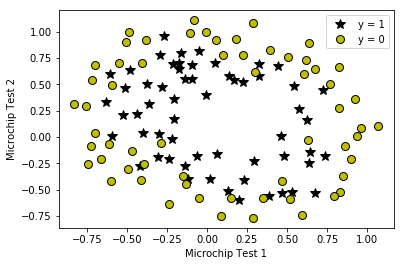

In [21]:
plotData(X, y)
# Labels and Legend
pyplot.xlabel('Microchip Test 1')
pyplot.ylabel('Microchip Test 2')

# Specified in plot order
pyplot.legend(['y = 1', 'y = 0'], loc='upper right')
pass

### 2.2 Feature mapping

In [22]:
X = utils.mapFeature(X[:, 0], X[:, 1])

In [23]:
X.shape

(118, 28)

### 2.3 Cost function and gradient

In [24]:
def costFunctionReg(theta, X, y, lambda_):
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(X.dot(theta))
    J = -1/m*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y)) + lambda_/2/m*np.sum(np.square(theta[1:]))
    grad = 1/m*X.T.dot(h-y) + lambda_/m*theta
    grad[0] = grad[0] - lambda_/m*theta[0]
    
    return J, grad

In [25]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')


Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


In [26]:
options = {'maxiter':400}

res = optimize.minimize(costFunction, initial_theta, (X,y), jac=True, method='TNC', options=options)

cost = res.fun

# the optimized theta is in the x property
theta = res.x

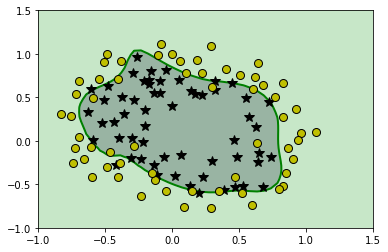

In [27]:
utils.plotDecisionBoundary(plotData, theta, X, y)

## 2.4 Optional exercises